In [3]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import time
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import pickle as pkl
import networkx as nx
import matplotlib.pyplot as plt
import pyomo.environ as pe

from scipy.stats import rv_histogram

import nice
from nice.reload import deep_reload

In [4]:
'''
Loading results
'''

results = {}

results['all'] = json.load(
    open('/media/aaron/Extreme SSD/nice_results/all/summary.json', 'r')
)

results['ccs'] = json.load(
    open('/media/aaron/Extreme SSD/nice_results/ccs/summary.json', 'r')
)

results['nacs'] = json.load(
    open('/media/aaron/Extreme SSD/nice_results/nacs/summary.json', 'r')
)

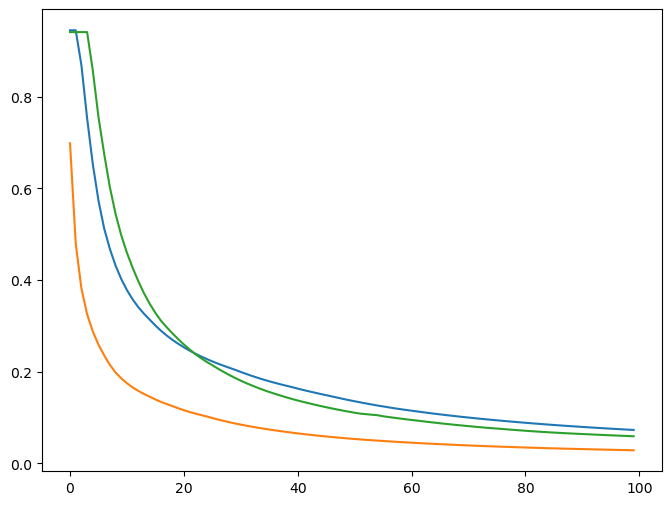

In [5]:
fig, ax = plt.subplots(figsize = (8, 6))

for k, v in results.items():
    
    # ax.plot(np.array(v['costs']) / max(v['costs']))
    ax.plot(1 - np.array(v['ratios']))

In [6]:
'''
Loading
'''

atlas = nice.graph.graph_from_json('Data/reduced_atlas.json')

graph_all = nice.graph.graph_from_json('Data/graph_100k.json')
graph_ccs = nice.graph.graph_from_json('Data/graph_ccs_100k.json')
graph_nacs = nice.graph.graph_from_json('Data/graph_nacs_100k.json')

paths_all = json.load(open('Data/paths_100k.json', 'r'))
paths_ccs = json.load(open('Data/paths_ccs_100k.json', 'r'))
paths_nacs = json.load(open('Data/paths_nacs_100k.json', 'r'))

In [7]:
'''
Selecting
'''

graph = graph_all
paths = paths_all

places = [k for k, n in graph._node.items() if 'station' not in k]
stations = [k for k, n in graph._node.items() if 'station' in k]

In [8]:
len([p for p in paths if len(p['path']) != 2])

74496

In [9]:
paths = [p for p in paths if len(p['path']) > 2]

In [10]:
'''
Setting travel demand
'''
deep_reload(nice)

p = [ 0.00890009, -0.00686443]
f = lambda d: p[0] * np.exp(p[1] * d)

kw = {
    'routing_weight': 'time',
    'production': 'population',
}

graph = nice.demand.demand(graph, places, **kw)

In [72]:
'''
Adding charging information at stations
'''
deep_reload(nice)

rng = np.random.default_rng(26589763514)

energy = 35 * 3.6e6
power = 80e3
m = 1 / (energy / power)
rho = np.concatenate((np.linspace(0, .8, 2), np.linspace(.81, .99, 20)))

delta = max(pcs)

delta = 50

for station in stations:

    node = graph._node[station]

    power = node['power_kw'] * 1e3
    m = 1 / (energy / power)
    n = node['port_count']
    lower_bound = max([n - delta, 0])
    upper_bound = n + delta
    c = list(range(lower_bound, upper_bound + 1))
    queue = nice.queue.Queue(m = m, rho = rho, c = c)
    
    volumes = np.array([rho * m * size for size in c])
    delays =  np.array(
        [queue.interpolate(rho, size)[0] * rho * m * size for size in c]
    )

    graph._node[station]['power'] = power
    graph._node[station]['volumes'] = np.atleast_2d(volumes)
    graph._node[station]['delays'] = np.atleast_2d(delays * volumes)
    graph._node[station]['expenditures'] = [c - n for c in c]

    # print(graph._node[station]['expenditures'])

In [73]:
'''
Adding classes and Building the network
'''
deep_reload(nice)

for place in places:

    graph._node[place]['_class'] = nice.optimization.Place

for station in stations:

    graph._node[station]['_class'] = nice.optimization.Station

for source, _adj in graph._adj.items():
    for target, edge in _adj.items():

        edge['_class'] = nice.optimization.Edge

for path in paths:
    
    path['_class'] = nice.optimization.Path

kw = {
    'verbose': True,
}

network = nice.optimization.Network(**kw).from_graph(graph, paths)

network.build()

Objects Built: 3.2238566875457764
Sets Built: 0.2296755313873291
Parameters Built: 1.2816452980041504
Variables Built: 4.656951189041138
Constraints Built: 3.069939613342285
Expenditure Built: 0.0938267707824707
Objective Built: 0.3554701805114746


In [74]:
'''
Solving the model
'''
deep_reload(nice)

kw = {
    'solver': {
        '_name': 'appsi_highs',
        'time_limit': 10 * 60,
    },
}

network.model.scale = 1e3 / 3600
network.model.penalty = 1
network.model.expenditure = 0
# network.model.expenditure_cost = 0

network.solve(**kw)
solution = network.solution

print('Objective Value:', network.objective_value)

Problem Solved: 120.701003074646
Results Collected: 1.053511619567871
Objective Value: 1070.4303598750062


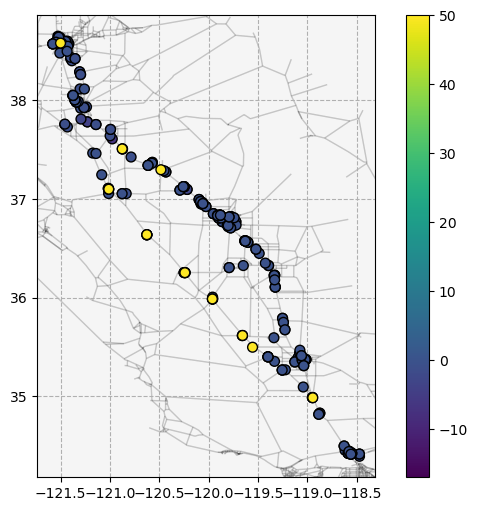

In [75]:
deep_reload(nice)

fig, ax = plt.subplots(figsize = (8, 6))

for source, node in solution._node.items():

    node['volume_h'] = node.get('volume', 0) * 3600
    node['optimal_ports'] = node.get('port_count', 0) + node.get('selection', 0) 

kw = {
    'nodes': {
        'selection': (
            [s for s in stations if solution._node[s]['optimal_ports'] > 0]
        ),
        # 'selection': stations,
        'field': 'optimal_ports',
        'field': 'selection',
        'colorbar': {},
        'plot': {
            's': 50,
            'zorder': 2,
            'ec': 'k',
        },
    },
}
    
sm = nice.plot.plot_graph(solution, ax = ax, **kw)

kw = {
    'edges': {
        'plot': {
            'lw': 1,
            'color': 'k',
            'alpha': .1,
            'zorder': 0,
        },
    },     
}
    
_ = nice.plot.plot_graph(atlas, ax = ax, **kw)

kw = {
    'facecolor': 'whitesmoke',
}

ax.set(**kw)

kw = {
    'ls': 'dashed',
}

ax.grid(**kw)

ax.set_aspect('equal')

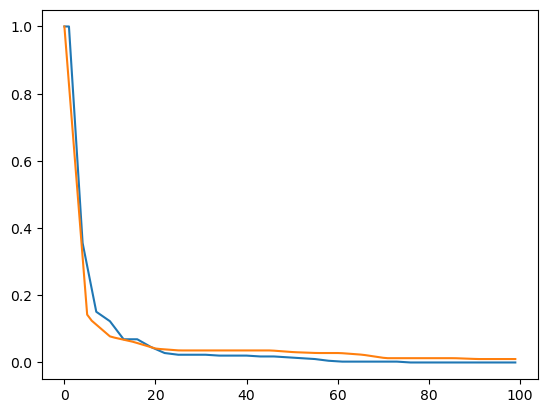

In [76]:
from scipy.stats import rv_histogram

pcs = np.array(
    [n['port_count'] for k, n in graph._node.items() if k in stations]
)

pcs_o = np.array(
    [n['optimal_ports'] for k, n in solution._node.items() if k in stations]
)

x = np.arange(0, 100, 1)
bins = 25

plt.plot(x, rv_histogram(np.histogram(pcs, bins = bins)).sf(x))
plt.plot(x, rv_histogram(np.histogram(pcs_o, bins = bins)).sf(x))

(array([253.,  79.,  15.,   7.,   7.,   4.,   1.,   3.,   1.,   2.,   0.,
          1.,   0.,   0.,   0.,   0.,   0.,   0.,   4.,   0.,   2.,   0.,
          3.,   1.,   1.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,   1.,
          0.,   0.,   0.,   0.,   1.,   0.,   1.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([  0.  ,   2.02,   4.04,   6.06,   8.08,  10.1 ,  12.12,  14.14,
         16.16,  18.18,  20.2 ,  22.22,  24.24,  26.26,  28.28,  30.3 ,
         32.32,  34.34,  36.36,  38.38,  40.4 ,  42.42,  44.44,  46.46,
         48.48,  50.5 ,  52.52,  54.54,  56.56,  58.58,  60.6 ,  62.62,
         64.64,  66.66,  68.68,  70.7 ,  72.72,  74.74,  76.76,  78.78,
         80.8 ,  82.82,  84.84,  86.86,  88.88,  90.9 ,  92.92,  94.94,
         96.96,  98.98, 101.  ]),
 <BarContainer object of 50 artists>)

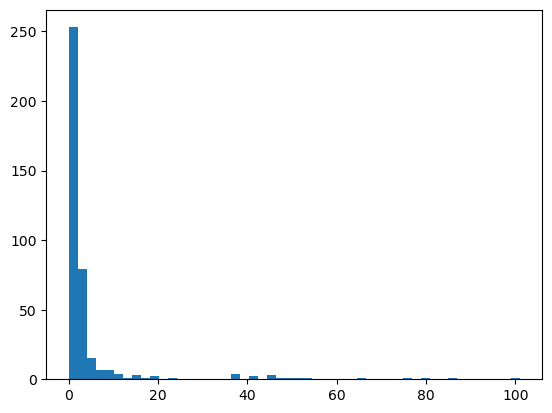

In [54]:
pcs = np.array(
    [n['optimal_ports'] for k, n in solution._node.items() if k in stations]
)

plt.hist(pcs, bins = 50)

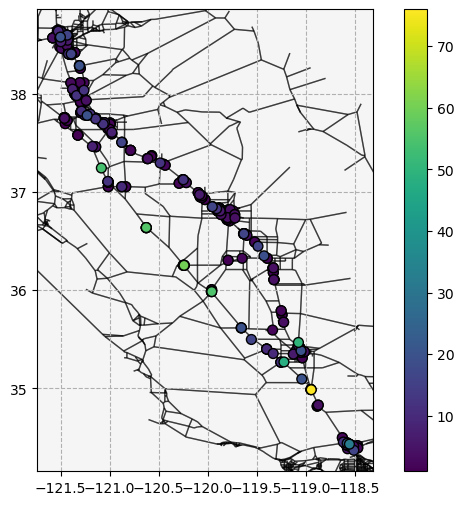

In [38]:
deep_reload(nice)

fig, ax = plt.subplots(figsize = (8, 6))

for source, node in solution._node.items():

    node['volume_h'] = node.get('volume', 0) * 3600
    node['optimal_ports'] = node.get('port_count', 0) + node.get('selection', 0) 

kw = {
    'nodes': {
        'selection': list(stations),
        'field': 'port_count',
        'colorbar': {},
        'plot': {
            's': 50,
            'zorder': 2,
            'ec': 'k',
        },
    },
}
    
sm = nice.plot.plot_graph(solution, ax = ax, **kw)

kw = {
    'edges': {
        'plot': {
            'lw': 1,
            'color': 'k',
            'alpha': .5,
            'zorder': 0,
        },
    },     
}
    
_ = nice.plot.plot_graph(atlas, ax = ax, **kw)

kw = {
    'facecolor': 'whitesmoke',
}

ax.set(**kw)

kw = {
    'ls': 'dashed',
}

ax.grid(**kw)

ax.set_aspect('equal')

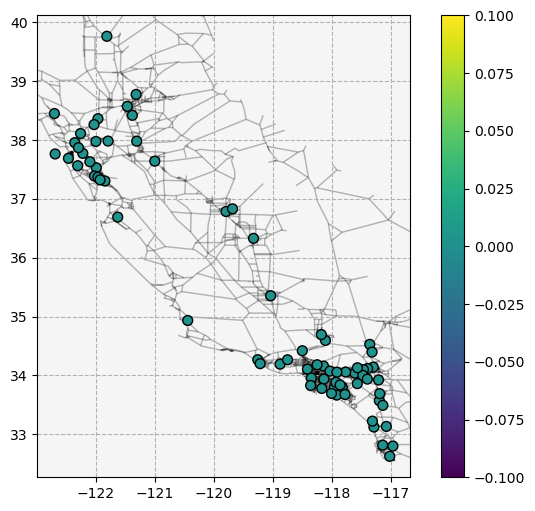

In [77]:
deep_reload(nice)

fig, ax = plt.subplots(figsize = (8, 6))

kw = {
    'nodes': {
        'selection': list(places),
        'field': 'direct_portion',
        'colorbar': {},
        'plot': {
            's': 50,
            'zorder': 2,
            'ec': 'k',
        },
    },
}
    
sm = nice.plot.plot_graph(solution, ax = ax, **kw)

kw = {
    'edges': {
        'plot': {
            'lw': 1,
            'color': 'k',
            'alpha': .15,
            'zorder': 0,
        },
    },     
}
    
_ = nice.plot.plot_graph(atlas, ax = ax, **kw)

kw = {
    'facecolor': 'whitesmoke',
}

ax.set(**kw)

kw = {
    'ls': 'dashed',
}

ax.grid(**kw)

ax.set_aspect('equal')

In [78]:
solution._node['Berkeley, CA']

{'x': -122.29891000959519,
 'y': 37.86639200970123,
 'population': 118715.0,
 'type': 'place',
 'flows': {'Temecula, CA': 4.2327670842863725e-06,
  'Visalia, CA': 2.8623492655560376e-05,
  'Santa Clara, CA': 8.462835498359203e-05,
  'San Bernardino, CA': 1.0625852651285913e-05,
  'Los Angeles, CA': 0.0002757771616710159,
  'Thousand Oaks, CA': 7.995558545725571e-06,
  'Victorville, CA': 7.490194862947106e-06,
  'Oxnard, CA': 1.5387232905938042e-05,
  'Santa Maria, CA': 1.64679464497375e-05,
  'Santa Rosa, CA': 0.00010896272526578483,
  'Salinas, CA': 7.143947006601026e-05,
  'Hayward, CA': 0.00012117922311553539,
  'Hesperia, CA': 5.132514738760504e-06,
  'Antioch, CA': 8.06980368514648e-05,
  'Garden Grove, CA': 9.491308914167563e-06,
  'Glendale, CA': 1.3408242051003453e-05,
  'Torrance, CA': 8.828272615000574e-06,
  'Fontana, CA': 1.077029487898499e-05,
  'San Jose, CA': 0.0006204527184585034,
  'Rialto, CA': 5.164324921402771e-06,
  'Escondido, CA': 5.009249399026896e-06,
  'Vallej